# Baseado no artigo do Ferreira.

6.754811525344849


Text(0.5, 1.0, 'OGA; ER; n=200; prob=6/n; ex:100val; ey:10val; i0=n*0.05; R0=0; λ=0.8; time=0.11min')

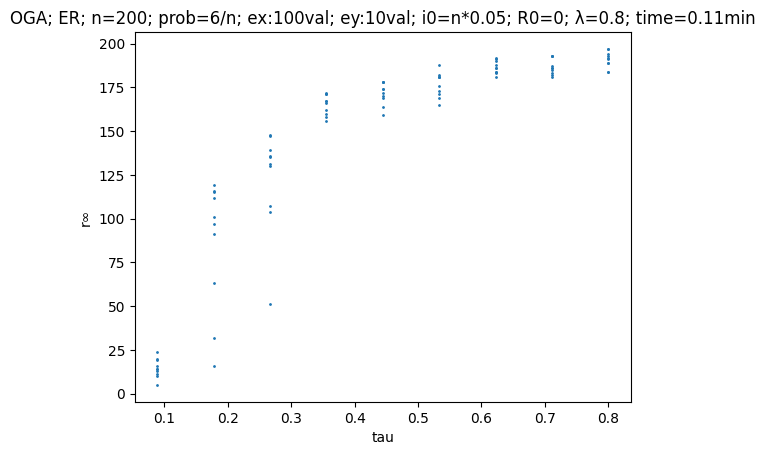

In [ ]:
import networkx as nx, numpy as np
import random as rd
import time

n_nodes = 200
prob = 6/n_nodes
G= nx.erdos_renyi_graph(n_nodes,prob)

#G= nx.erdos_renyi_graph(50,0.5)
dic = nx.convert.to_dict_of_dicts(G)
sordic = sorted(dic.keys())
adj_mtz = {}
for i in sordic:
    adj_mtz.update({i:dic[i]})

# Tempo do código
start = time.time()

# Para fins de plot
n_τ_plot = []
n_rec_plot = []

# Lista das taxas de infecção
list_τ = np.linspace(0.0,0.8,10)

# Número de repetições:
n_rep = 10

# Rodando a dinâmica
for τ in list_τ:
    for rep in range(n_rep):


        # taxa de recuperação
        λ = 0.8

        # Condições iniciais
        size = n_nodes   # Número de vértices

        dyn_VI = np.zeros(size, int)                # lista de infectados com indices 'dyn_NI'
        dyn_sig = np.zeros(size, int)               # Lista com as informações dos compartimentos S = 0, I = 1

        dynp_pINI = 0.05  # Fração inicial de i0

        dyn_sig[:] = 0.0  # Compartimentos: S = 0, I = 1
        dyn_VI[:] = 0.0   # Lista de índices 'dyn_NI' com cada um direcionando a um vértice infectado.
        dyn_NI = 0       # Número de infectados na dinâmica (usado como lista de índice)
        dyn_Nk = 0       # Número de arestas conectadas aos infectados
        dyn_NR = 0       # Número de recuperados na dinâmica.

        # k_max é o maior número de arestas que um vértice pode ter.
        k_max = 0
        for chave, valor in adj_mtz.items():
            if len(valor) > k_max:
                k_max = len(valor)


        # Infectados iniciais: i0
        for i in range(0, int(size*dynp_pINI)): # dynp_pINI é uma fração e size é o número de vértices totais
            while True:

               # Sorteia um vertice aleatório
                ver = np.random.randint(0,size)

                # Se ele for suscetível: S = 0
                if dyn_sig[ver] == 0:

                   # Adiciona na lista de infectados o vértice 'ver' no índice 'dyn_NI'
                   dyn_VI[dyn_NI] = ver

                   # Aumenta o número de infectados
                   dyn_NI += 1

                   # Muda de S = 0 para I = 0
                   dyn_sig[ver] = 1

                   # Aumenta número total de arestas conectadas aos infectados.
                   dyn_Nk += np.size(list(adj_mtz[ver]))

                   break


        # Dinâmica

        dyn_t = 0
        dyn_dt = 0.0
        dyn_dt_pos = 0.01

        #n_inf = []
        #n_time = []
        n_rec = []
        n_τ = []

        while dyn_NI > 0: #dyn_t <= dynp_tmax

            # dyn_R: Taxa total
            # 1.0*dyn_NI: taxa total de recuperação. Uma é a taxa de recuperação e o dyn_NI é o número de infectados.
            # τ*dyn_Nk: taxa total de infecção. τ taxa de infecção, dyn_Nk é a soma total de arestas de todos os infectados.
            dyn_R = (λ*dyn_NI + 1.0*τ*dyn_Nk)

            # Penso ser o 1.0 multiplicando apenas para o resultado ser um número flutuante e evitar problemas.

            # Probabilidade de se recuperar
            dyn_m = λ*dyn_NI/dyn_R

            # Atualizando o tempo
            rnd = max(np.random.uniform(),1e-12) # evitar u = 0
            dyn_dt = -np.log(rnd)/dyn_R
            dyn_t += dyn_dt

            # Processo de recuperação
            if np.random.uniform() < dyn_m:

                # Seciono um vértice aleatório dentro dos índices 'dyn_NI'
                pos_inf = np.random.randint(0,dyn_NI)

                # Procuro dentro da lista 'dyn_VI' no índice 'pos_inf' o vértice infectado 'ver'.
                ver = dyn_VI[pos_inf]

                # Recupero ele.

                # Mudo de I = 1 para R = 2
                dyn_sig[ver] = 2

                # Reduzo o número de arestas conectadas aos infectados
                dyn_Nk -= np.size(list(adj_mtz[ver]))

                # Diminuo o número de infectados
                dyn_NI -= 1

                # Muda de lugar o último termo da lista de infectados 'dyn_VI'
                    # para o índice do vértice que acabou de ser recuperado. Diminuindo a lista em 1.
                dyn_VI[pos_inf] = dyn_VI[dyn_NI]

                # Aumento o número de recuperados
                dyn_NR += 1

                # Processo de infecção
            else:

                # Selecionando um vértice i com a probabilidade ki/kmáx (arestas_de_i/aresta_máxima_da_rede)
                while True:
                    pos_inf = np.random.randint(0,dyn_NI)
                    ver = dyn_VI[pos_inf]

                    # Número de arestas k de ver
                    k = np.size(list(adj_mtz[ver]))

                    # Probabilidade de ser escolhido: k/k_max.
                    if np.random.uniform() < 1.0*k / (1.0*k_max):
                        break

                # Selecionando um de seus vizinhos
                viz = np.random.choice(list(adj_mtz[ver]))

                # Se o vizinho selecionado for suscetível, haverá uma infecção.
                    # Se não é um processo "fantasma".
                if dyn_sig[viz] == 0:

                    # Mudando de S para I
                    dyn_sig[viz] = 1

                    # Aumentando o número de arestas conectadas aos infectados.
                    dyn_Nk += np.size(list(adj_mtz[viz]))

                    # Aumentando um elemento da lista
                    dyn_VI[dyn_NI] = viz

                    # Aumentando em 1 a lista
                    dyn_NI += 1


                # Salvando a dinamica por unidade de tempo
                while (dyn_t >= dyn_dt_pos): # Save data
                    dyn_dt_pos += 0.01
                    #n_inf.append(dyn_NI)
                    #n_time.append(dyn_t)
                    n_rec.append(dyn_NR)

        try:
            n_rec_plot.append(n_rec[-1])
            n_τ_plot.append(τ)
        except IndexError:
            continue

# Tempo do código
stop = time.time()
print(stop - start)

import matplotlib.pyplot as plt
plt.scatter(n_τ_plot, n_rec_plot, s=1)
plt.xlabel('tau')
plt.ylabel('r∞')
plt.title(f"OGA; ER; n={n_nodes}; prob=6/n; ex:100val; ey:{n_rep}val; i0=n*0.05; R0=0; λ={λ}; time={round((stop - start)/60,2)}min")
#plt.savefig(f'OGA;ER;n={n_nodes};100x{n_rep}.pdf')

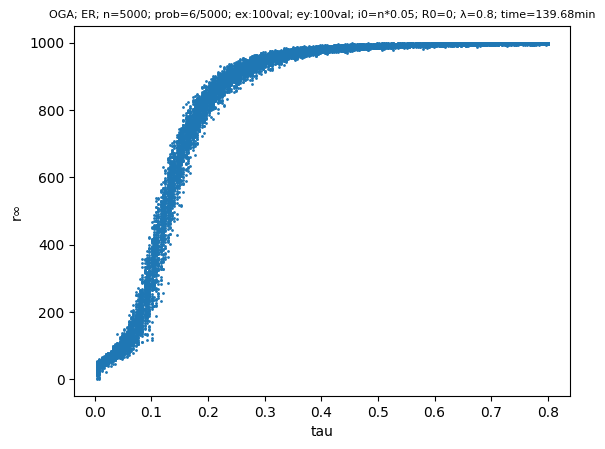

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(n_τ_plot, n_rec_plot, s=1)
plt.xlabel('tau')
plt.ylabel('r∞')
plt.title(f"OGA; ER; n={n_nodes}; prob=6/{n_nodes}; ex:100val; ey:{n_rep}val; i0=n*0.05; R0=0; λ={λ}; time={round((stop - start)/60,2)}min", fontsize=8)
plt.savefig(f'OGA;ER;n={n_nodes};100x{n_rep}.pdf')

In [ ]:
for chave, valor in adj_mtz.items():
    if len(valor) > k_max:
        k_max = len(valor)

In [ ]:
n_nodes = 100
prob = 6/n_nodes
G= nx.erdos_renyi_graph(n_nodes,prob)

#G= nx.erdos_renyi_graph(50,0.5)
dic = nx.convert.to_dict_of_dicts(G)
sordic = sorted(dic.keys())
adj_mtz = {}
for i in sordic:
    adj_mtz.update({i:dic[i]})

In [ ]:
for chave, valor in adj_mtz.items():
    if len(valor) > k_max:
        k_max = len(valor)
k_max

16

In [ ]:
a, b = adj_mtz.items()

ValueError: too many values to unpack (expected 2)